    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.

# Load and preprocess dataset

Load the dataset skipping some columns. This time use the category datatype for the classification column.

In [36]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [37]:
csv_file = 'datasets/netflow-v1/NF-BoT-IoT.csv'
ignore_cols = {'IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Label'}

In [38]:
df = pd.read_csv(csv_file,
                 usecols=lambda x: x not in ignore_cols,
                 dtype={'Attack': 'category'})
df.head()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Attack
0,52670,53,17,5.212,71,126,1,1,0,4294966,Benign
1,49160,4444,6,0.000,217753000,199100,4521,4049,24,4176249,Theft
2,3456,80,17,0.000,8508021,8918372,9086,9086,0,4175916,Benign
3,80,8080,6,7.000,8442138,9013406,9086,9086,0,4175916,Benign
4,80,80,6,7.000,8374706,0,9086,0,0,4175916,Benign


The decision tree and random forest classifiers work best with unnormalised data but the VAE requires inputs to conform to a standard normal distribution.
This is done using the `transform` and `inverse_transform` methods from the `StandardScaler` class. Before use, the scaler must be 'fit' to the data to caluclate the mean and standard deviation for each feature.

In [39]:
scaler = StandardScaler().fit(df.iloc[:,:-1])

# Train classifier model

In [40]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [280]:
X, y = df.iloc[:,:-1], df.iloc[:,-1].cat.codes
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [281]:
classifier = XGBClassifier(n_estimators=17, tree_method='gpu_hist', random_state=42)
classifier.fit(X_train, y_train);

In [282]:
"{:.2%}".format(classifier.score(X_test, y_test))

'84.06%'

# Train explanation model

The VAE implementation is copied from the paper though the model was altered slightly to suit our dataset.

In [451]:
from collections import Counter

import numpy as np
import torch
import torch.nn as nn

from tqdm import tqdm

The encoder takes a batch of rows (32 by default) from the training dataset. This is fed forward into a hidden layer first and then into two fully connected layers with outputs of size `z_dim`, which is the size of the latent vector. This is then used to parameterise a normal distribution, which is sampled from to produce the output latents.

In [284]:
class Encoder(nn.Module):
    def __init__(self, x_dim, z_dim, hidden_dim=100):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(int(x_dim),hidden_dim),
            nn.Sigmoid()
        )
        
        self.f_mu = nn.Linear(hidden_dim, z_dim)
        self.f_var = nn.Linear(hidden_dim, z_dim)

    def encode(self, X):
        h1 = self.model(X)
        return self.f_mu(h1),self.f_var(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, X):
        mu, logvar = self.encode(X)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

In [285]:
class Decoder(nn.Module):
    def __init__(self, x_dim, z_dim, hidden_dim=100):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(z_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,x_dim)
        )

    def forward(self, z):
        X = self.model(z)
        return X  

In [286]:
K = 2
L = 8

In [287]:
X_train_norm = scaler.transform(X_train)
train_loader = torch.utils.data.DataLoader(X_train_norm, batch_size=32)
encoder = Encoder(X_train.shape[1], K+L)
decoder = Decoder(X_train.shape[1], K+L)
decoder.cuda()
encoder.cuda();

In [288]:
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.0001)

In [301]:
def calc_loss(X, Xhat, z_loc, z_scale):
    batch_size = X.shape[0]
    sse_loss = torch.nn.MSELoss(reduction = 'sum')
    KLD = 1./batch_size + -0.5*torch.sum(1 + z_scale - z_loc.pow(2) - z_scale.exp())
    Xhat = torch.Tensor(Xhat).cuda()
    mse = 1./batch_size * sse_loss(Xhat, X)
    return mse + KLD

This is the function from the paper to calculate the "causal effect" or mutual information between the causal latents and classifier result. The `Counter` part is a dirty hack as the function expects 'one-hot' encoded classifier output but XGBoost only produces ordinal results.

In [297]:
eps = 1e-8

def C(a: int, b: int, cats: int, *, independent=False, conditional=False):
    z = a + b

    I = 0.
    qs = np.zeros(cats)
    for _ in range(a):
        alphas = np.random.randn(a)
        latents = np.empty((b,z))

        for j in range(b):
            betas = np.random.randn(b)
            latents[j] = np.concatenate((alphas, betas))

        Xhat_norm = decoder(torch.from_numpy(latents).cuda().float())
        Xhat = scaler.inverse_transform(Xhat_norm.cpu().detach())
        df_test = pd.DataFrame(Xhat, columns=X.columns)
        
        yhat = classifier.predict(df_test)
        yhat = [y for _, y in sorted(Counter(yhat).items())]
        
        ps = np.sum(yhat, axis=0) / b # p(y | alpha)
        ps_entropy = np.sum(ps * np.log(ps + eps))
        I += ps_entropy / a
        qs += ps / a # q(y)
    qs_entropy = np.sum(qs * np.log(qs+eps))
    I -= qs_entropy
    return I

In [293]:
def train(use_cuda=False):
    epoch_loss = 0.
    
    for X in tqdm(train_loader):
        if use_cuda:
            X = X.cuda()
        X = X.float()
        optimizer.zero_grad()
        z, z_loc, z_scale = encoder(X)
        Xhat = scaler.inverse_transform(decoder(z).cpu().detach())
        loss = -C(K, L, df['Attack'].cat.categories.size) + 0.05 * calc_loss(X, Xhat, z_loc, z_scale)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    return epoch_loss / train_loader.dataset.shape[0]

In [302]:
train(True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14065/14065 [05:45<00:00, 40.66it/s]


tensor(2.2238e+10, device='cuda:0', grad_fn=<DivBackward0>)

In [303]:
X_test_norm = scaler.transform(X_test)

In [309]:
z, _, _ = encoder(torch.tensor(X_test_norm).cuda().float())
X_test_hat = scaler.inverse_transform(decoder(z).cpu().detach())

In [310]:
df_test = pd.DataFrame(X_test_hat, columns=X.columns)
df_test

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS
0,49441.630445,4535.121318,5.957367,4.316928,-20070.817899,225201.589038,-24.289550,-96.436631,24.221310,3.375833e+06
1,48844.493260,10401.785117,5.997656,-3.637923,35001.434427,305919.819421,40.084300,-45.668975,21.616578,3.810941e+06
2,44978.776688,4787.834187,5.879647,4.171412,-49067.997906,-25953.064851,60.795832,1.339769,23.797595,3.686100e+06
3,47070.157734,3946.341907,6.024747,-8.466394,138211.235494,205439.639245,-28.006685,-27.754949,22.634254,3.686835e+06
4,47759.407667,5619.237715,6.505894,-1.572597,171720.356053,425903.542881,-72.519695,50.974016,21.705975,3.711313e+06
...,...,...,...,...,...,...,...,...,...,...
150020,48642.147922,3016.264756,6.013393,-5.532205,-211087.301595,183043.278544,-82.980857,-139.560303,23.581319,2.844693e+06
150021,53999.177966,5617.136242,6.272739,-10.039050,-149112.159713,155973.327340,-37.462396,-86.433347,22.085490,3.084295e+06
150022,43535.034015,2506.699537,5.938288,-0.300310,-52772.758200,181827.727473,15.568934,-44.966364,25.229510,3.292002e+06
150023,46042.740891,7354.597081,6.784626,11.142359,-31249.025523,271345.821080,25.115436,30.346044,23.633643,3.577367e+06


In [452]:
"{:.2%}".format(classifier.score(df_test, y_test))

'51.13%'

# Visualisation

In [427]:
z_sweep = range(-30, 30, 5)
sweep_X = X_test_norm[0]

In [434]:
enc_z, _, _ = encoder(torch.tensor(sweep_X).cuda().float())

In [435]:
classifier.predict(scaler.inverse_transform(decoder(enc_z).cpu().detach().reshape(1,-1)))

array([4], dtype=int64)

In [436]:
zz = []
for nudge in z_sweep:
    ar = enc_z.clone()
    ar[0:K] += nudge
    dec_X = scaler.inverse_transform(decoder(ar).cpu().detach().reshape(1, -1))
    zz.append((
        ar,
        dec_X,
        classifier.predict(dec_X)
    ))

In [437]:
print("Sweeping from -30 to +30 in steps of 5")
cats = df['Attack'].cat.categories
for enc, dec, res in zz:
    causal = [int(x) for x in enc.tolist()[:K]]
    print(f"Causal vars: {causal}, result: {cats[res][0]}")

Sweeping from -30 to +30 in steps of 10
Causal vars: [-30, -30], result: DDoS
Causal vars: [-25, -25], result: DDoS
Causal vars: [-20, -20], result: DDoS
Causal vars: [-15, -15], result: DoS
Causal vars: [-10, -10], result: DoS
Causal vars: [-5, -5], result: Reconnaissance
Causal vars: [0, 0], result: Theft
Causal vars: [4, 4], result: Benign
Causal vars: [9, 9], result: Reconnaissance
Causal vars: [14, 14], result: Reconnaissance
Causal vars: [19, 19], result: Reconnaissance
Causal vars: [24, 24], result: Reconnaissance


In [444]:
before = sweep_X
after = scaler.transform(zz[7][1])
feature_names = df.columns[:-1]

C:\Users\lh\dev\causal-ids\.env\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [109]:
import matplotlib.pyplot as plt

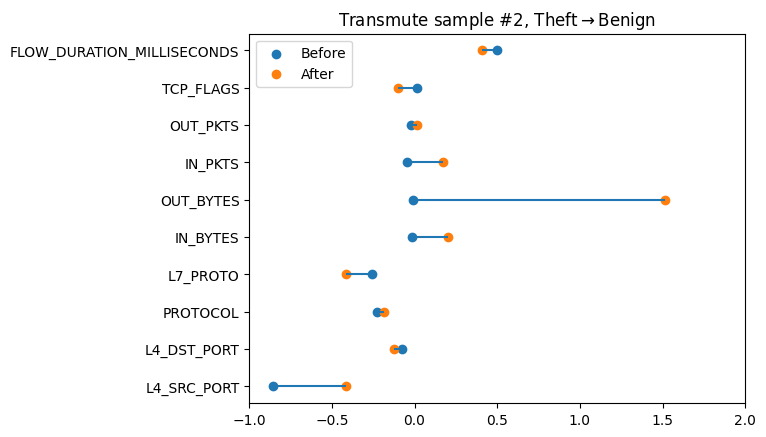

In [445]:
plt.scatter(before, feature_names, label='Before')
plt.scatter(after, feature_names, label='After')
plt.hlines(y=feature_names, xmin=before, xmax=after)
plt.legend(loc='upper left')
plt.title('Transmute sample #2, Theft$\\rightarrow$Benign')
plt.xlim([-1,2])
plt.savefig('tranmuted_sample.png', bbox_inches = "tight");

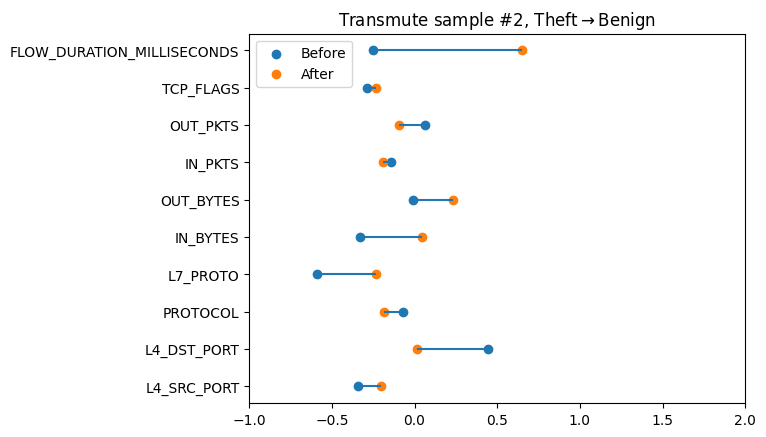

In [173]:
plt.scatter(before, feature_names, label='Before')
plt.scatter(after, feature_names, label='After')
plt.hlines(y=feature_names, xmin=before, xmax=after)
plt.legend(loc='upper left')
plt.title('Transmute sample #2, Theft$\\rightarrow$Benign')
plt.xlim([-1,2])
plt.savefig('tranmuted_sample.png', bbox_inches = "tight");

In [131]:
zz = []
for nudge in z_sweep:
    ar = enc_z.clone()
    ar[-L:] += nudge
    dec_X = decoder(ar)
    zz.append((
        ar,
        dec_X,
        classifier.predict(dec_X.view([1,10]).cpu().detach())
    ))

[(tensor([ -0.2867,  -0.5033, -15.8557, -13.4280, -13.9199, -12.2570, -15.0056,
          -14.5525, -14.5837, -14.7357], device='cuda:0', grad_fn=<CopySlices>),
  tensor([ 0.0871, -0.1905, -0.1415, -0.4027, -0.4773, -0.2441, -0.0410, -0.5929,
          -0.0137,  0.4059], device='cuda:0', grad_fn=<AddBackward0>),
  array([3], dtype=int64)),
 (tensor([ -0.2867,  -0.5033, -10.8557,  -8.4280,  -8.9199,  -7.2570, -10.0056,
           -9.5525,  -9.5837,  -9.7357], device='cuda:0', grad_fn=<CopySlices>),
  tensor([ 0.0402, -0.1408, -0.0588, -0.2071, -0.3192, -0.1498, -0.0411, -0.3869,
          -0.0286,  0.2589], device='cuda:0', grad_fn=<AddBackward0>),
  array([3], dtype=int64)),
 (tensor([-0.2867, -0.5033, -5.8557, -3.4280, -3.9199, -2.2570, -5.0056, -4.5525,
          -4.5837, -4.7357], device='cuda:0', grad_fn=<CopySlices>),
  tensor([-0.0250, -0.0845,  0.0289, -0.0286, -0.1693, -0.0571, -0.0287, -0.1746,
          -0.0314,  0.1025], device='cuda:0', grad_fn=<AddBackward0>),
  array([3],

In [132]:
print("Sweeping from -30 to +30 in steps of 5")
cats = df['Attack'].cat.categories
for enc, dec, res in zz:
    noncausal = [int(x) for x in enc.tolist()[-L:]]
    print(f"Non-causal vars: {noncausal}, result: {cats[res][0]}")

Sweeping from -30 to +30 in steps of 10
Non-causal vars: [-15, -13, -13, -12, -15, -14, -14, -14], result: Reconnaissance
Non-causal vars: [-10, -8, -8, -7, -10, -9, -9, -9], result: Reconnaissance
Non-causal vars: [-5, -3, -3, -2, -5, -4, -4, -4], result: Reconnaissance
Non-causal vars: [0, 1, 1, 2, 0, 0, 0, 0], result: Benign
Non-causal vars: [4, 6, 6, 7, 4, 5, 5, 5], result: Reconnaissance
Non-causal vars: [9, 11, 11, 12, 9, 10, 10, 10], result: Theft
Non-causal vars: [14, 16, 16, 17, 14, 15, 15, 15], result: Theft


In [122]:
print("Feature importance:")
for feature, importance in zip(X.columns, classifier.feature_importances_):
    print(f"{feature}: {importance:.2f}")

Feature importance:
L4_SRC_PORT: 0.02
L4_DST_PORT: 0.59
PROTOCOL: 0.07
L7_PROTO: 0.03
IN_BYTES: 0.02
OUT_BYTES: 0.06
IN_PKTS: 0.00
OUT_PKTS: 0.04
TCP_FLAGS: 0.09
FLOW_DURATION_MILLISECONDS: 0.08
